# Deep learning framework example

This notebook demonstrates how to use the deeplearning API to train and test the model on the [Iris dataset](https://archive.ics.uci.edu/ml/datasets/iris).

To install the necessary software, use `make deps` in the root directory of the project.  If you don't have make installed or don't want to use it, then use:

`pip install -r src/python/requirements.txt`

In [1]:
# set up notebook environment
import sys
app_root_dir = '..'
sys.path.append(app_root_dir + '/src/python')
sys.path.append(app_root_dir + '/test/python')

from zensols.deeplearn import TorchConfig
# set the random seed so things are predictable
TorchConfig.set_random_seed()

## Create the object factory

This creates a factoty that instantiates Python objects using a simple configuration (INI).  This removes much of the complexity of creating and "hooking up" all the instances.

In [2]:
import logging
from zensols.config import ExtendedInterpolationEnvConfig as AppConfig
from zensols.config import ImportConfigFactory
from zensols.deeplearn.result import ModelResultGrapher

# configure the environment
config = AppConfig(app_root_dir + '/test-resources/iris/iris.conf',
                   env={'app_root': app_root_dir})

# create a factoty that instantiates Python objects using a simple configuration (INI)
factory = ImportConfigFactory(config, shared=True)

## Create the model executor

Use the factory to create the model executor (see the `executor` section of `test-resources/iris/iris.conf`).  The `write` method gives statistics on the data set that is configured on the executor.

In [3]:
executor = factory('executor')
executor.write()

feature splits:
    data frame splits:
        dev: 12 (8.0%)
        test: 25 (16.7%)
        train: 113 (75.3%)
        total: 150
batch splits:
    split stash splits:
        dev: 1 (11.1%)
        test: 2 (22.2%)
        train: 6 (66.7%)
        total: 9
    total this instance: 9
    keys consistent: True


## Print the model

Every time the executor is told to train, it creates a new model.  It also stores this model to the disk every time the validation loss drops.  The method that controls the creation if `create_model`.  Note this creates a new PyTorch `torch.nn.Module` every time and isn't the same instance used by the executor.

In this case, a four deep fully connected network is created and fanned out from the 4 features (from four columns from the CSV file) to 20.  This is then reduce to the output layer having three neurons indicating which type of flower (setosa, versicolor, or virginica).

In [4]:
print(executor.create_model())

IrisNetwork(
  (fc): Linear(in_features=4, out_features=3, bias=True)
)


## Train and test the model

This trains the model on the Iris (flower) data set and prints the results.  The PyTorch model itself is also printed.

train: 13.372, valid: 5.445 \/: 100%|███████████| 3/3 [00:00<00:00, 101.55it/s]

restting dataset result 'test'
Name: Iris
Run index: 1
Learning rate: 0.1
    train:
        started: 05/26/2020 18:43:21:138061
        ended: 05/26/2020 18:43:21:168220
        num epochs: 3
        num data points per epoc: 113
        epoch converged: 2
        average loss: 13.372444748878479
        min loss: 7.714423179626465
        num outcomes: 113
        micro: F1: 0.292, precision: 0.29, recall: 0.29
        macro: F1: 0.313, precision: 0.36, recall: 0.29
    validation:
        num epochs: 3
        num data points per epoc: 12
        epoch converged: 2
        average loss: 5.445345640182495
        min loss: 5.445345640182495
        num outcomes: 12
        micro: F1: 0.750, precision: 0.75, recall: 0.75
        macro: F1: 0.608, precision: 0.57, recall: 0.67
    test:
        started: 05/26/2020 18:43:21:221741
        ended: 05/26/2020 18:43:21:222661
        num epochs: 1
        num data points per epoc: 25
        epoch converged: 0
        average loss: 6.661247

AttributeError: 'ModelResult' object has no attribute 'micro_metrics'

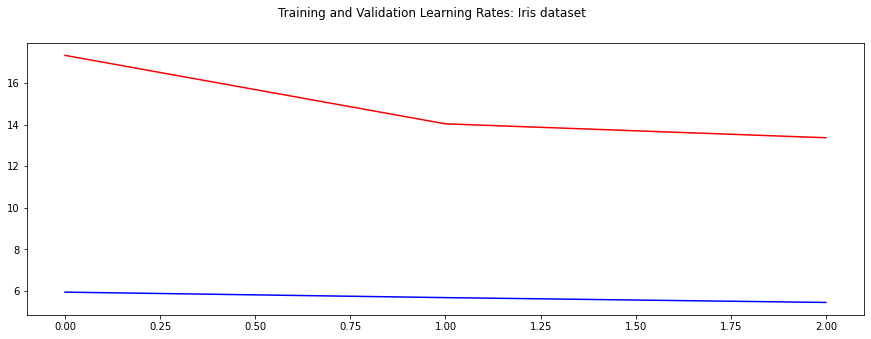

In [5]:
# tell the executor to give us console output
executor.progress_bar = True

# train the model
executor.train()

# test the model
res = executor.test()

# write a summary of the results
res.write()

# graph the results
grapher = ModelResultGrapher('Iris dataset', [15, 5])
grapher.plot([res])

## Fine tune setting hyperparameters

Now that we have our model training and we have evaluated the results, we see the validation loss is very spiky.  This means our learning rate is probably too high as when it moves during stochastic gradient descent it is "jumping" too far and back up the error surface.

To fix that, let's decrease the learning rate.  We can do that by adjusting the hyperparameters directly on the executor.

In [ ]:
def run_model():
    # reset all state from the previous train/test
    executor.reset()
    # train/test
    executor.train()
    res = executor.test()
    # results
    res.write()
    grapher = ModelResultGrapher('Iris dataset', [15, 5])
    grapher.plot([res])

# set the number of epochs and learning rate, which are both model parameters
executor.set_model_parameter('epochs', 200)
executor.set_model_parameter('learning_rate', .001)

# run the model with the new
run_model()

## Network parameters

While we're at it, let's also adjust the drop out, which is a network settings, to see if we can get better results.  Also note that the model converged pretty late indicating we aren't over training, so add more epochs.

In [ ]:
# set a network parameter
executor.set_network_parameter('dropout', 0.1)
executor.set_model_parameter('epochs', 700)
executor.set_model_parameter('learning_rate', .001)
run_model()

## Predictions

The executor contains the results from the last run, in additional to saving it.  In our case, we have the same instance of the model we just tested, which contains not only the performance metrics, but the predictions themselves.  Use `get_predictions` to get a Pandas `pd.DataFrame` for the results.

In [ ]:
# optionally, we can transform the data point instance used, otherwise it defaults to `str`
def map_data_point(dp):
    """Map the data point's Pandas row information (pd.Series) to key/value string.
    
    """
    s = ', '.join(map(lambda x: f'{x[0]}={x[1]}', dp.row.iteritems()))
    return (s,)
df = executor.get_predictions(transform=map_data_point)
df